In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.stats.api as sms

In [12]:
from scipy.stats import norm
import math

def calculate_sample_size_conversion(alpha, power, p1, p2):
    """
    Calculate the sample size needed for comparing two conversion rates.
    
    Parameters:
    alpha (float): Significance level (e.g., 0.05)
    power (float): Statistical power (e.g., 0.80 for 80% power)
    p1 (float): Conversion rate for the first group
    p2 (float): Conversion rate for the second group
    
    Returns:
    int: Total sample size needed per group
    """
    # Calculate Z-scores for alpha and power
    Z_alpha = norm.ppf(1 - alpha / 2)
    Z_beta = norm.ppf(power)
    
    # Calculate the pooled proportion
    p_pooled = (p1 + p2) / 2
    
    # Calculate the standard deviations
    std_pooled = math.sqrt(2 * p_pooled * (1 - p_pooled))
    std_diff = math.sqrt(p1 * (1 - p1) + p2 * (1 - p2))
    
    # Calculate the sample size
    sample_size = ((Z_alpha * std_pooled + Z_beta * std_diff) / (p1 - p2)) ** 2
    sample_size = math.ceil(sample_size)
    
    return sample_size

# Example usage
alpha = 0.05  # Significance level
power = 0.80  # Power
p1 = 0.20  # Conversion rate for the first group
delta = 0.004 # Minimum Detectable Effect
p2 = p1 + delta

sample_size = calculate_sample_size_conversion(alpha, power, p1, p2)
print(f"Total sample size needed per group: {sample_size}")

Total sample size needed per group: 158150


In [3]:
#------------------ Simulating Clck Data fo A/N Testing ----------------------------#
N_exp = sample_size
N_con = sample_size

# Generating Click Data
click_exp = pd.Series(np.random.binomial(1,0.21, size = N_exp))
click_con = pd.Series(np.random.binomial(1,0.2, size = N_con))

# Generate Group Identifier
exp_id = pd.Series(np.repeat('exp' , N_exp))
con_id = pd.Series(np.repeat('con' , N_con))

df_exp = pd.concat([click_exp, exp_id] , axis = 1)
df_con = pd.concat([click_con, con_id] , axis = 1)

df_exp.columns = ["click" , "group"]
df_con.columns = ['click' , 'group']


df_ab_test = pd.concat([df_exp , df_con] , axis = 0).reset_index(drop = True)

X_con = df_ab_test.groupby("group")['click'].sum().loc['con']
X_exp = df_ab_test.groupby("group")['click'].sum().loc['exp']

print("Number of Clicks in Control: " , X_con)
print("Number of Clicks in Experimental: " , X_exp)

p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp

print("click Probabiltity in Control Group: ", p_con_hat)
print("click Probabiltity in Experimental Group: ", p_exp_hat)

p_pooled_hat = (X_con + X_exp) / (N_con + N_exp)

pooled_variance = p_pooled_hat * ( 1 - p_pooled_hat) * ( 1/ N_con + 1 / N_exp)
print("p^_pooled is " , p_pooled_hat)
print("pooled_variance is: ",pooled_variance)

SE = np.sqrt(pooled_variance)
print("Standard Error is : " , SE)

Test_stat = (p_exp_hat -  p_con_hat)/SE
print("Test Statistics for 2-sample Z-test is : ", Test_stat)

alpha = 0.05
print("Alpha: significance level is : ", alpha)

Z_crit = norm.ppf(1 - alpha / 2)
print("Z-critical value from Standard Normal distribution: ", Z_crit)

p_value =  norm.sf(abs(Test_stat))
print("P-value of the 2-sample Z-test: ", round(p_value , 3))

CI = [round((p_exp_hat -  p_con_hat) - SE * Z_crit, 3) , round((p_exp_hat -  p_con_hat) + SE * Z_crit, 3)]
print("Cinfidence Interval of the 2 sample Z-test is : ", CI)

Number of Clicks in Control:  31655
Number of Clicks in Experimental:  33195
click Probabiltity in Control Group:  0.20015807777426495
click Probabiltity in Experimental Group:  0.20989566866898515
p^_pooled is  0.20502687322162505
pooled_variance is:  2.0612185201212614e-06
Standard Error is :  0.001435694438284575
Test Statistics for 2-sample Z-test is :  6.782495379974493
Alpha: significance level is :  0.05
Z-critical value from Standard Normal distribution:  1.959963984540054
P-value of the 2-sample Z-test:  0.0
Cinfidence Interval of the 2 sample Z-test is :  [0.007, 0.013]


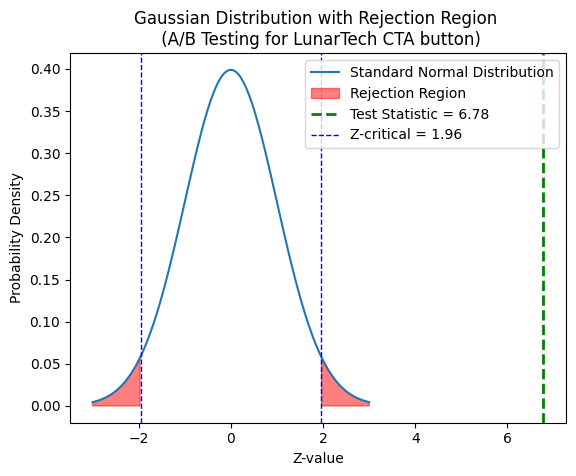

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters for the standard normal distribution
mu = 0  # Mean
sigma = 1  # Standard deviation

# Define the range of x values
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

# Calculate the y values for the standard normal distribution
y = norm.pdf(x, mu, sigma)

# Plotting the standard normal distribution
plt.plot(x, y, label='Standard Normal Distribution')

# Define the critical value for the rejection region (Z_crit)
Z_crit = Z_crit  # for a 95% confidence level (two-tailed test)

# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label='Rejection Region')

# Adding Test Statistic
Test_stat = Test_stat  # Example test statistic
plt.axvline(Test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_stat:.2f}')

# Adding Z-critical values
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1)

# Adding labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing for LunarTech CTA button)')
plt.legend()

# Show plot
plt.show()

In [5]:
def is_Practically_significant(delta, CI_95):
    """
    We assess if the difference between Control and Experimental group is practically significant using the Minimum Detectable Effect (MDE).
    
    Arguments:
    delta (float): The Minimum Detectable Effect (MDE) considered for practical significance.
    CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% Confidence Interval.
    
    Returns:
    bool: True if practically significant, False otherwise.
    """
    
    # Extract lower bound of 95% Confidence Interval
    Lower_bound_CI = CI[0]
    
    # Check if the lower bound of the CI is greater than or equal to delta
    if Lower_bound_CI >= delta:
        print(f"We have practical significance! \nWith MDE of {delta}, the difference between Control and Experimental group is practically significant.")
        return True
    else:
        print("We don't have practical significance! \nThe difference between Control and Experimental group is not practically significant.")
        return False


# Call the function
significant = is_Practically_significant(delta , CI)
print("Lower bound of 95 % confidence interval is: ", CI[0])

We have practical significance! 
With MDE of 0.004, the difference between Control and Experimental group is practically significant.
Lower bound of 95 % confidence interval is:  0.007


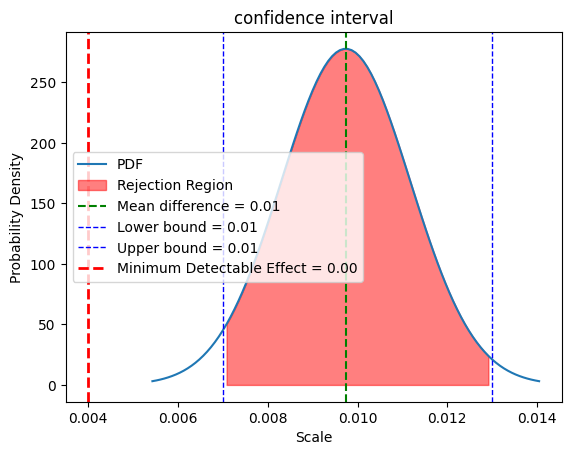

In [6]:
# Parameters for the standard normal distribution
mu = (p_exp_hat -  p_con_hat)  # Mean
sigma = SE  # Standard deviation

# Define the range of x values
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

# Calculate the y values for the standard normal distribution
y = norm.pdf(x, mu, sigma)

# Plotting the standard normal distribution

plt.plot(x, y, label='PDF')

# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > round((p_exp_hat -  p_con_hat) - SE * Z_crit, 3)) & (x < round((p_exp_hat -  p_con_hat) + SE * Z_crit, 3)), color='red', alpha=0.5, label='Rejection Region')

# Add critical value and annotation
plt.axvline(x=(p_exp_hat -  p_con_hat), color='green', linestyle='--', label=f'Mean difference = {(p_exp_hat -  p_con_hat):.2f}')

# Adding Z-critical values
plt.axvline(round((p_exp_hat -  p_con_hat) - SE * Z_crit, 3), color='blue', linestyle='dashed', linewidth=1, label=f'Lower bound = {round((p_exp_hat -  p_con_hat) - SE * Z_crit, 3):.2f}')
plt.axvline(round((p_exp_hat -  p_con_hat) + SE * Z_crit, 3), color='blue', linestyle='dashed', linewidth=1, label=f'Upper bound = {round((p_exp_hat -  p_con_hat) + SE * Z_crit, 3):.2f}')

plt.axvline(delta, color='red', linestyle='dashed', linewidth=2, label=f'Minimum Detectable Effect = {delta:.2f}')

# Adding labels and title
plt.xlabel('Scale')
plt.ylabel('Probability Density')
plt.title('confidence interval')
plt.legend()

# Show plot
plt.show()

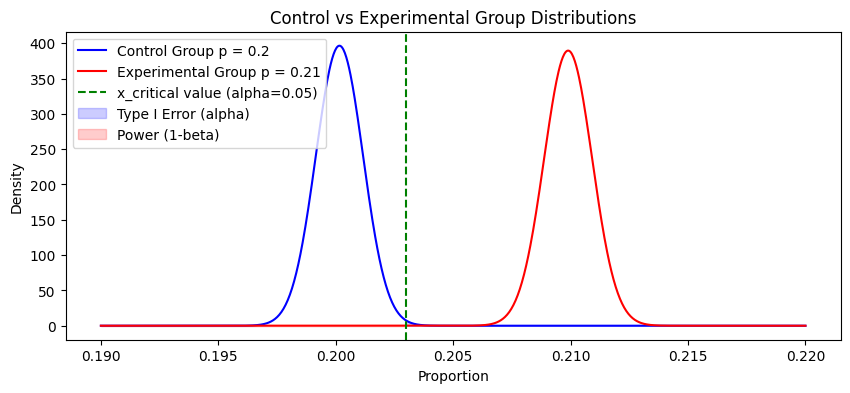

In [7]:
# Generate normal distributions
x = np.linspace(0.19, 0.22, 1000)
control_dist = norm(loc=p_con_hat, scale=np.sqrt(p_con_hat * (1 - p_con_hat) / sample_size))
experiment_dist = norm(loc=p_exp_hat, scale=np.sqrt(p_exp_hat * (1 - p_exp_hat) / sample_size))

# Plot the distributions
plt.figure(figsize=(10, 4))
plt.plot(x, control_dist.pdf(x), label=f'Control Group p = {round(p_con_hat, 2)}', color='blue')
plt.plot(x, experiment_dist.pdf(x), label=f'Experimental Group p = {round(p_exp_hat, 2)}', color='red')

# Significance level and critical value
z_critical = norm.ppf(1 - alpha / 2)
#x_critical = p_con_hat + z_critical * np.sqrt(p_con_hat * (1 - p_con_hat) / sample_size)
x_critical = p_con_hat + z_critical * SE
plt.axvline(x=x_critical, color='green', linestyle='--', label=f'x_critical value (alpha={alpha})')

# Fill areas for alpha and power
plt.fill_betweenx(y=control_dist.pdf(x), x1=x, x2=x_critical, where=(x >= x_critical), color='blue', alpha=0.2, label='Type I Error (alpha)')
plt.fill_betweenx(y=experiment_dist.pdf(x), x1=x, x2=x_critical, where=(x <= x_critical), color='red', alpha=0.2, label='Power (1-beta)')

plt.title('Control vs Experimental Group Distributions')
plt.xlabel('Proportion')
plt.ylabel('Density')
plt.legend()
plt.show()


In [8]:
# Decision based on the test
if p_value < alpha:
    print(f"Reject null hypothesis: p-value = {p_value:.4f}")
else:
    print(f"Fail to reject null hypothesis: p-value = {p_value:.4f}")

# Calculate Type 1 and Type 2 errors
if p_value < alpha:
    # Null hypothesis is rejected
    if (p_con_hat + delta) <= p_con_hat + SE * Z_crit:
        print(f"Type 1 error occurred")
    else:
        print(f"No Type 1 error occurred")
else:
    # Null hypothesis is not rejected
    if (p_con_hat + delta) > p_con_hat + SE * Z_crit:
        print(f"Type 2 error occurred")
    else:
        print(f"No Type 2 error occurred")

# Calculate statistical power (1 - beta)
beta = norm.cdf(Z_crit - delta/ SE)
statistical_power = 1 - beta
print(f"Statistical power (1 - beta): {statistical_power:.4f}")

Reject null hypothesis: p-value = 0.0000
No Type 1 error occurred
Statistical power (1 - beta): 0.7956
